In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
# Trova tutti i file CSV che seguono il pattern 2023_*.csv
mainpath = '/home/gabriele/Scrivania/BUILDON/PILOT 4/P4 - EDF/Building electricity consumption/K0XRLNlG_2023-01-01_2024-08-28/K0XRLNlG/'
file_list = glob.glob(f'{mainpath}2023_*.csv') + glob.glob(f'{mainpath}2024_*.csv')

# Lista per contenere i DataFrame letti
df_list = []

# Leggi ciascun file CSV e aggiungi il DataFrame risultante alla lista
for file in file_list:
    df = pd.read_csv(file)
    df_list.append(df)

# Concatena tutti i DataFrame in un unico DataFrame
df_combinato = pd.concat(df_list, ignore_index=True)
df_combinato['dateTime'] = pd.to_datetime(df_combinato['dateTime'])
df_combinato = df_combinato.sort_values(by='dateTime')



In [2]:
# Filtra le righe per il consumo elettrico (PC ed Eclairage)
df_consumo_elettrico = df_combinato[df_combinato['equipmentName'].str.contains('PC|Eclairage', case=False, na=False)]

# Filtra per unità di misura in KWH
df_consumo_elettrico = df_consumo_elettrico[df_consumo_elettrico['unit'].str.contains('KWH', case=False, na=False)]

# Assicurati che la colonna 'dateTime' sia nel formato datetime
df_consumo_elettrico['dateTime'] = pd.to_datetime(df_consumo_elettrico['dateTime'])

# Rimuovi eventuali duplicati basandoti su 'dateTime'
df_consumo_elettrico = df_consumo_elettrico.drop_duplicates(subset='dateTime')

# Seleziona solo le colonne numeriche (escludi le colonne non numeriche come 'equipmentName' e 'unit')
df_numerico = df_consumo_elettrico.select_dtypes(include=['number'])

# Aggiungi di nuovo la colonna 'dateTime' alle colonne numeriche
df_numerico['dateTime'] = df_consumo_elettrico['dateTime']

# Imposta 'dateTime' come indice
df_numerico = df_numerico.set_index('dateTime')

# Esegui il resampling per intervalli giornalieri ('D') e calcola la media giornaliera
df_consumo_elettrico_resampled = df_numerico.resample('D').mean()

# Reset dell'indice se necessario
df_consumo_elettrico_resampled = df_consumo_elettrico_resampled.reset_index()
df_consumo_elettrico_resampled = df_consumo_elettrico_resampled.drop(['scaledPayload', 'timestamp'], axis=1)
df_consumo_elettrico_resampled = df_consumo_elettrico_resampled.rename(columns={"payload": "Valore"})

# Salva il nuovo dataset in un CSV
#df_consumo_elettrico_resampled.to_csv("dataset_media_giornaliera.csv", index=False)


In [3]:

# Filtra le righe per il consumo HVAC (Chauffage)
df_consumo_hvac = df_combinato[df_combinato['equipmentName'].str.contains('Chauffage', case=False, na=False)]

# Filtra per unità di misura in KWH
df_consumo_hvac = df_consumo_hvac[df_consumo_hvac['unit'].str.contains('KWH', case=False, na=False)]


# Assicurati che la colonna 'dateTime' sia nel formato datetime
df_consumo_hvac['dateTime'] = pd.to_datetime(df_consumo_hvac['dateTime'])

# Rimuovi eventuali duplicati basandoti su 'dateTime'
df_consumo_hvac = df_consumo_hvac.drop_duplicates(subset='dateTime')

# Seleziona solo le colonne numeriche (escludi le colonne non numeriche come 'equipmentName' e 'unit')
df_numerico_hvac = df_consumo_hvac.select_dtypes(include=['number'])

# Aggiungi di nuovo la colonna 'dateTime' alle colonne numeriche
df_numerico_hvac['dateTime'] = df_consumo_hvac['dateTime']

# Imposta 'dateTime' come indice
df_numerico_hvac = df_numerico_hvac.set_index('dateTime')

# Esegui il resampling per intervalli giornalieri ('D') e calcola la media giornaliera
df_numerico_hvac_resampled = df_numerico_hvac.resample('D').mean()

# Reset dell'indice se necessario
df_numerico_hvac_resampled = df_numerico_hvac_resampled.reset_index()
df_numerico_hvac_resampled = df_numerico_hvac_resampled.drop(['scaledPayload', 'timestamp'], axis=1)
df_numerico_hvac_resampled = df_numerico_hvac_resampled.rename(columns={"payload": "Valore"})


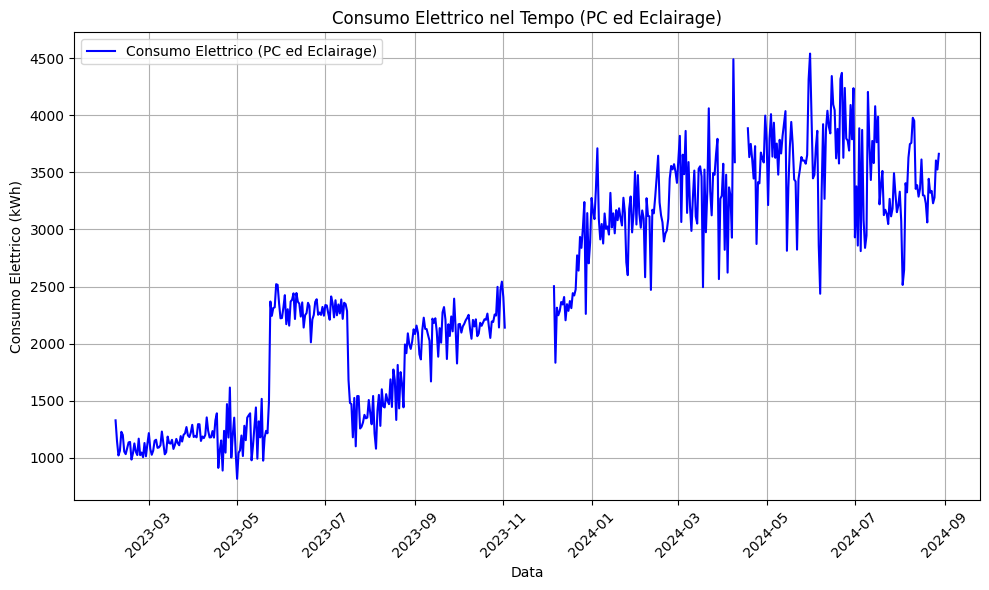

In [4]:
# Grafico per il consumo elettrico
plt.figure(figsize=(10, 6))
plt.plot(df_consumo_elettrico_resampled['dateTime'], df_consumo_elettrico_resampled['Valore'], label='Consumo Elettrico (PC ed Eclairage)', color='blue')
plt.title('Consumo Elettrico nel Tempo (PC ed Eclairage)')
plt.xlabel('Data')
plt.ylabel('Consumo Elettrico (kWh)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


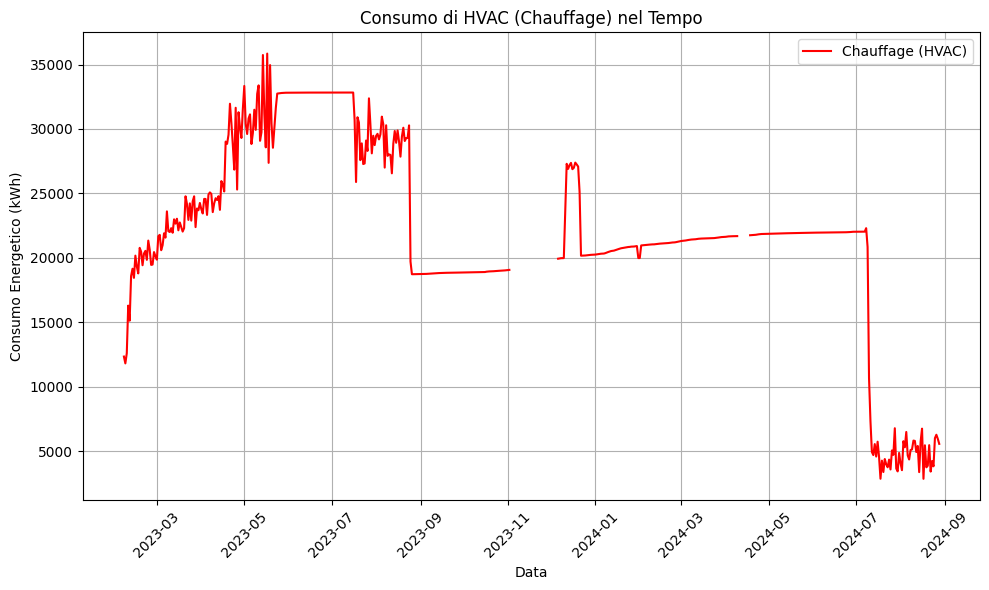

In [5]:
# Secondo grafico: Consumo di HVAC (Chauffage) nel tempo
plt.figure(figsize=(10, 6))
plt.plot(df_numerico_hvac_resampled['dateTime'], df_numerico_hvac_resampled['Valore'], label='Chauffage (HVAC)', color='r')
plt.title('Consumo di HVAC (Chauffage) nel Tempo')
plt.xlabel('Data')
plt.ylabel('Consumo Energetico (kWh)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


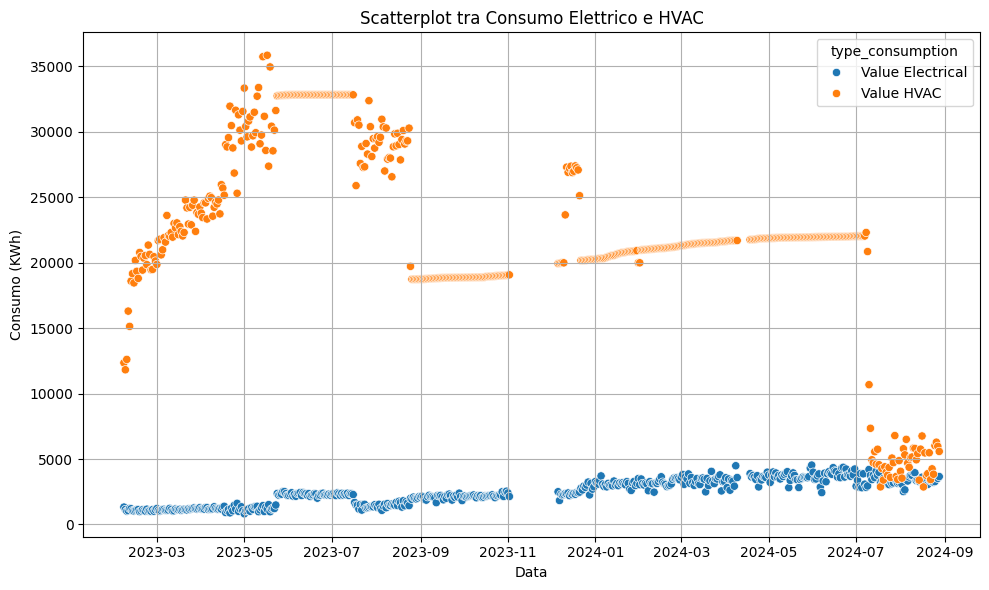

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Unione dei due DataFrame resampled (consumo elettrico e HVAC)
df_unito = pd.merge(df_consumo_elettrico_resampled, df_numerico_hvac_resampled, on='dateTime', suffixes=('_elettrico', '_hvac'))

df_unito = df_unito.rename(columns={"Valore_elettrico": "Value Electrical"})
df_unito = df_unito.rename(columns={"Valore_hvac": "Value HVAC"})

# Riorganizza i dati in formato "long" per fare un plot con 'hue'
df_long = pd.melt(df_unito, id_vars=['dateTime'], value_vars=['Value Electrical', 'Value HVAC'],var_name='type_consumption', value_name='consumption')

# Creazione dello scatterplot con differenziazione basata su tipo_consumo (elettrico o hvac)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='dateTime', y='consumption', hue='type_consumption', data=df_long)

# Titolo e etichette
plt.title('Scatterplot tra Consumo Elettrico e HVAC')
plt.xlabel('Data')
plt.ylabel('Consumo (KWh)')
plt.grid(True)
plt.tight_layout()
# Mostra il plot
plt.show()


In [7]:
# Trova tutti i file CSV per le condizioni meteo
mainpath2 = '/home/gabriele/Scrivania/BUILDON/PILOT 4/P4 - EDF/Weather conditions/csvimportati/'
file_list2 = glob.glob(f'{mainpath2}export_*.csv')

# Lista per contenere i DataFrame letti
df_list2 = []

# Leggi ciascun file CSV e aggiungi il DataFrame risultante alla lista
for file in file_list2:
    df2 = pd.read_csv(file, sep=';')
    df_list2.append(df2)

# Concatena tutti i DataFrame in un unico DataFrame
df_combinato2 = pd.concat(df_list2, ignore_index=True)
df_combinato2['Date'] = pd.to_datetime(df_combinato2['Date'], dayfirst=True)
df_combinato2 = df_combinato2.sort_values(by='Date')



/tmp/ipykernel_180543/86059535.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_meteo_selezionato['Temperature(°C)'] = pd.to_numeric(df_meteo_selezionato['Temperature(°C)'], errors='coerce')
/tmp/ipykernel_180543/86059535.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_meteo_selezionato['Pressure(mb)'] = pd.to_numeric(df_meteo_selezionato['Pressure(mb)'], errors='coerce')
/tmp/ipykernel_180543/86059535.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

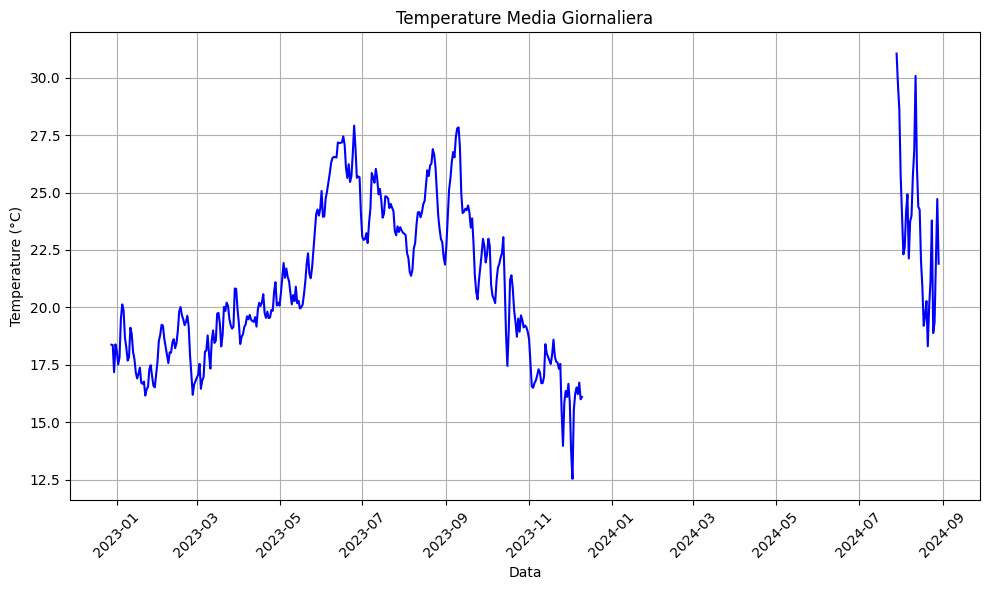

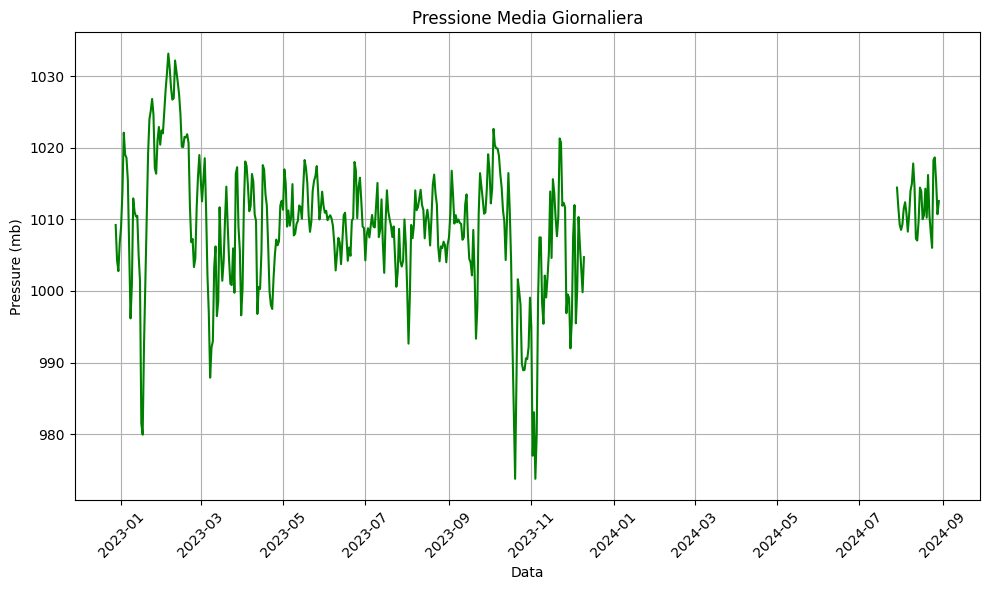

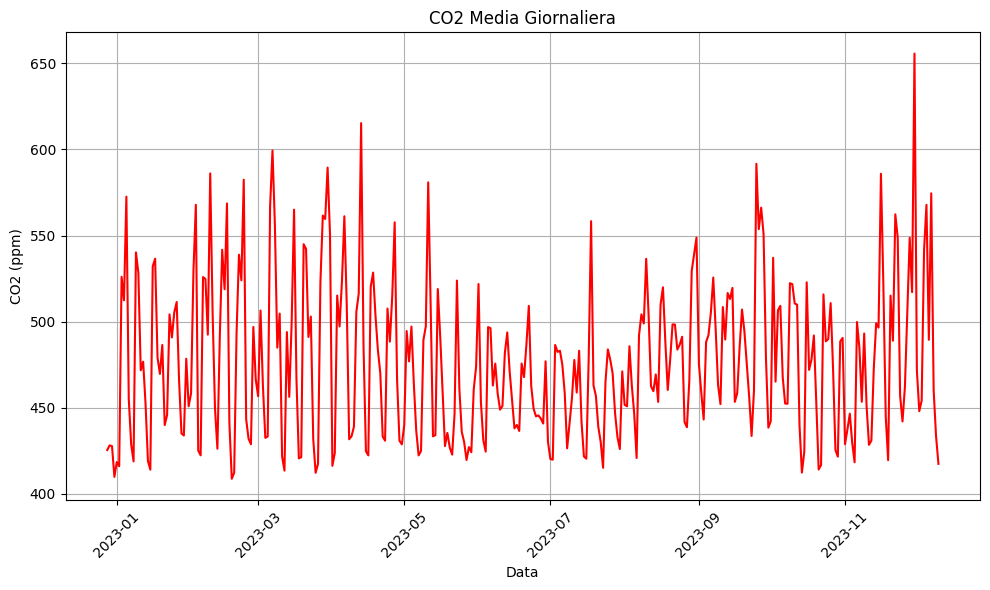

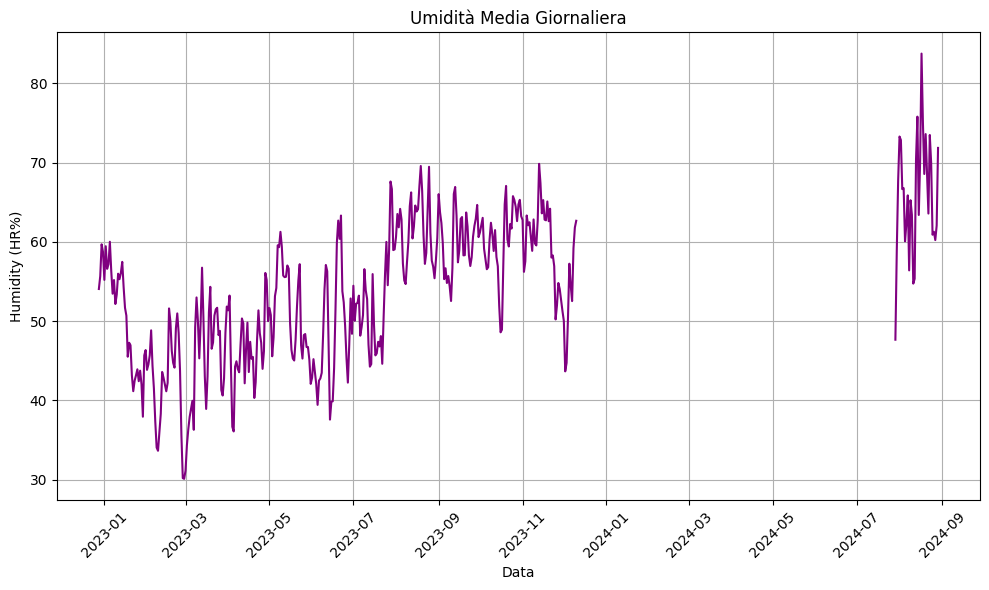

In [8]:
# Filtra solo le colonne rilevanti (Temperature(°C), Pressure(mb), CO2(ppm) e Humidity(HR%))
df_meteo_selezionato = df_combinato2[['Date', 'Temperature(°C)', 'Pressure(mb)', 'CO2(ppm)', 'Humidity(HR%)']]

# Assicurati che le colonne siano numeriche
df_meteo_selezionato['Temperature(°C)'] = pd.to_numeric(df_meteo_selezionato['Temperature(°C)'], errors='coerce')
df_meteo_selezionato['Pressure(mb)'] = pd.to_numeric(df_meteo_selezionato['Pressure(mb)'], errors='coerce')
df_meteo_selezionato['CO2(ppm)'] = pd.to_numeric(df_meteo_selezionato['CO2(ppm)'], errors='coerce')
df_meteo_selezionato['Humidity(HR%)'] = pd.to_numeric(df_meteo_selezionato['Humidity(HR%)'], errors='coerce')

# Imposta 'Date' come indice
df_meteo_selezionato = df_meteo_selezionato.set_index('Date')

# Esegui il resampling giornaliero e calcola la media per ciascuna variabile
df_meteo_resampled = df_meteo_selezionato.resample('D').mean()

# Reset dell'indice se necessario
df_meteo_resampled = df_meteo_resampled.reset_index()

# Creazione dei grafici per ciascuna variabile
plt.figure(figsize=(10, 6))
plt.plot(df_meteo_resampled['Date'], df_meteo_resampled['Temperature(°C)'], label='Temperature (°C)', color='blue')
plt.title('Temperature Media Giornaliera')
plt.xlabel('Data')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(df_meteo_resampled['Date'], df_meteo_resampled['Pressure(mb)'], label='Pressure (mb)', color='green')
plt.title('Pressione Media Giornaliera')
plt.xlabel('Data')
plt.ylabel('Pressure (mb)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(df_meteo_resampled['Date'], df_meteo_resampled['CO2(ppm)'], label='CO2 (ppm)', color='red')
plt.title('CO2 Media Giornaliera')
plt.xlabel('Data')
plt.ylabel('CO2 (ppm)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Grafico per l'umidità
plt.figure(figsize=(10, 6))
plt.plot(df_meteo_resampled['Date'], df_meteo_resampled['Humidity(HR%)'], label='Humidity (HR%)', color='purple')
plt.title('Umidità Media Giornaliera')
plt.xlabel('Data')
plt.ylabel('Humidity (HR%)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [9]:
# Trova la prima e l'ultima data nella colonna 'timestamp'
from datetime import timedelta

prima_data = df_meteo_resampled['Date'].min()
ultima_data = df_meteo_resampled['Date'].max()
data_primadeidatimancanti = pd.Timestamp('2023-12-10') 
# Mostra la prima e l'ultima data
print(f"La prima data è: {prima_data}")

print(f"L'ultima data è: {ultima_data}")
print(f"L'ultima data prima dei missing data è : {data_primadeidatimancanti}")
# Filtra il DataFrame
df_meteo_resampled = df_meteo_resampled[(df_meteo_resampled['Date'] >= prima_data) & (df_meteo_resampled['Date'] < data_primadeidatimancanti + timedelta(days=1)
)]
df_meteo_resampled
prima_data = df_meteo_resampled['Date'].min()
ultima_data = df_meteo_resampled['Date'].max()

# Mostra la prima e l'ultima data
print(f"La prima data è: {prima_data}")

print(f"L'ultima data è: {ultima_data}")


La prima data è: 2022-12-28 00:00:00
L'ultima data è: 2024-08-29 00:00:00
L'ultima data prima dei missing data è : 2023-12-10 00:00:00
La prima data è: 2022-12-28 00:00:00
L'ultima data è: 2023-12-10 00:00:00


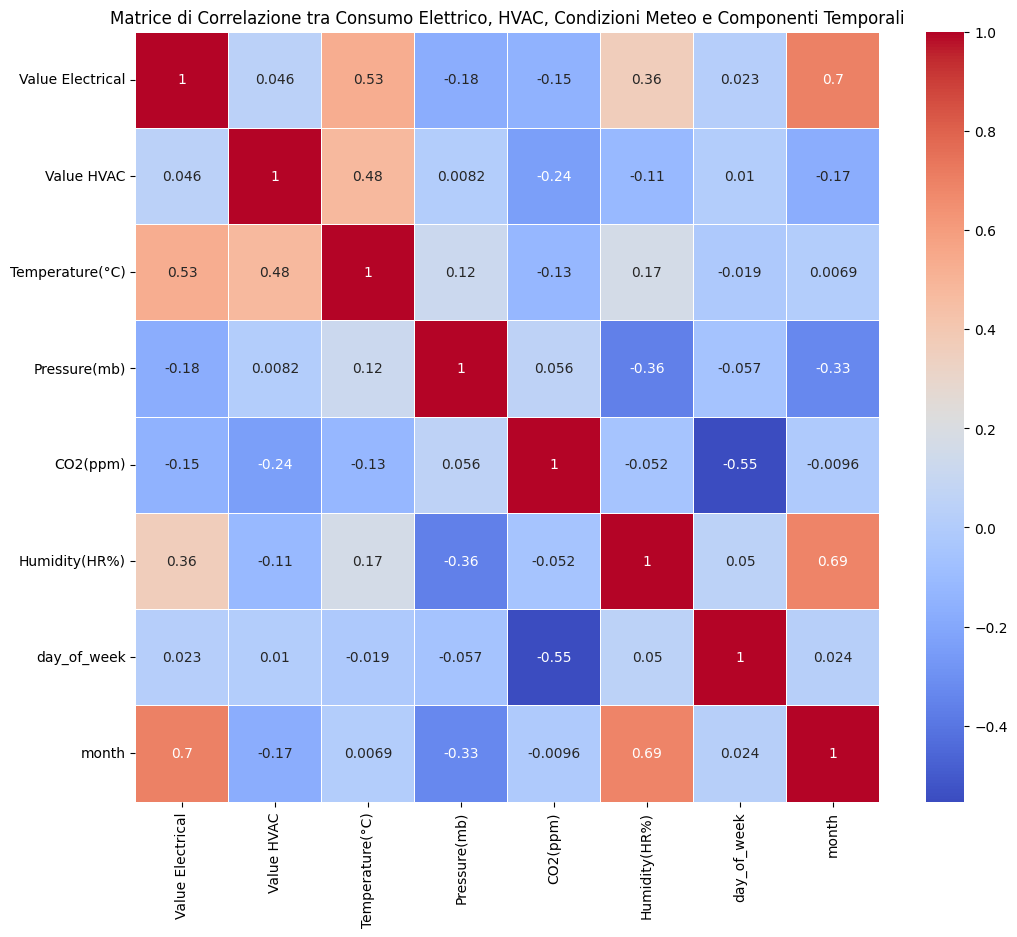

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Unione dei due DataFrame resampled (consumo elettrico e HVAC)
df_unito = pd.merge(df_consumo_elettrico_resampled, df_numerico_hvac_resampled, on='dateTime', suffixes=('_elettrico', '_hvac'))

# Aggiungi i dati meteo al DataFrame unito
df_unito = pd.merge(df_unito, df_meteo_resampled, left_on='dateTime', right_on='Date')
# Estrai componenti temporali
#df_unito['hour'] = df_unito['dateTime'].dt.hour
df_unito['day_of_week'] = df_unito['dateTime'].dt.dayofweek
df_unito['month'] = df_unito['dateTime'].dt.month
# Seleziona le colonne per la correlazione, includendo le nuove componenti temporali
df_correlation = df_unito[['Valore_elettrico', 'Valore_hvac', 'Temperature(°C)', 'Pressure(mb)','CO2(ppm)', 'Humidity(HR%)', 'day_of_week', 'month']]
df_correlation = df_correlation.rename(columns={"Valore_elettrico": "Value Electrical"})
df_correlation = df_correlation.rename(columns={"Valore_hvac": "Value HVAC"})
# Calcola la matrice di correlazione
correlation_matrix = df_correlation.corr()
# Visualizza la heatmap della matrice di correlazione
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
# Titolo della heatmap
plt.title('Matrice di Correlazione tra Consumo Elettrico, HVAC, Condizioni Meteo e Componenti Temporali')
# Mostra il plot
plt.show()


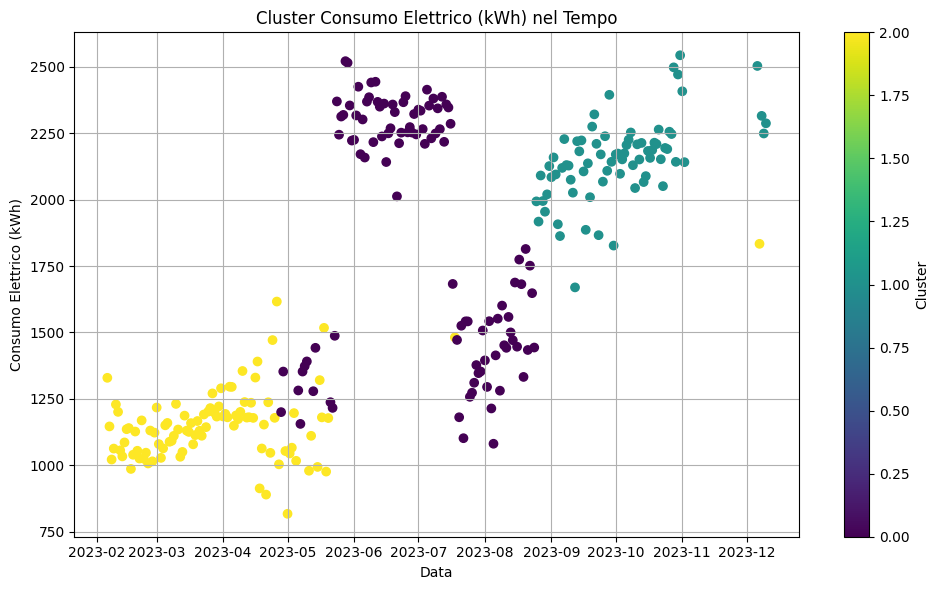

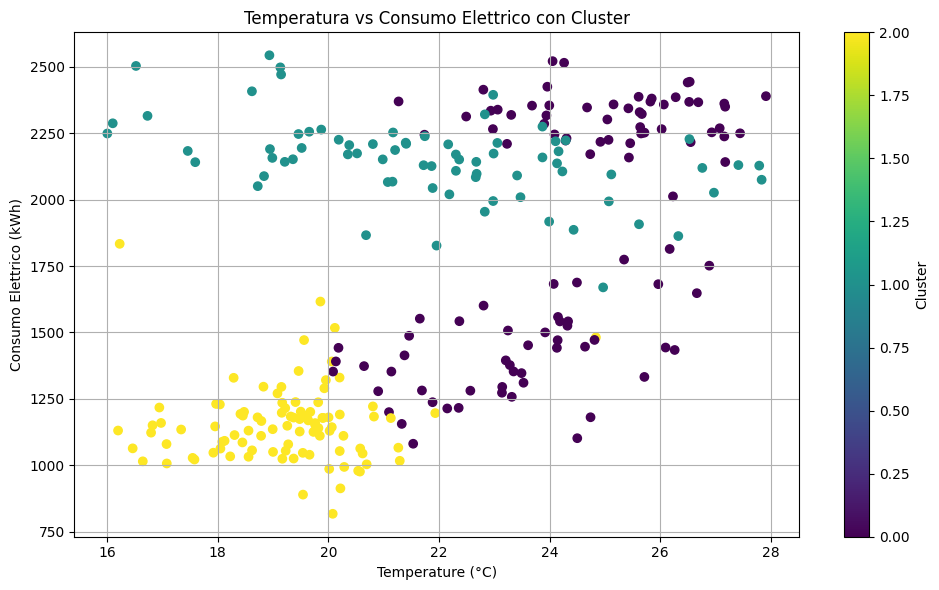

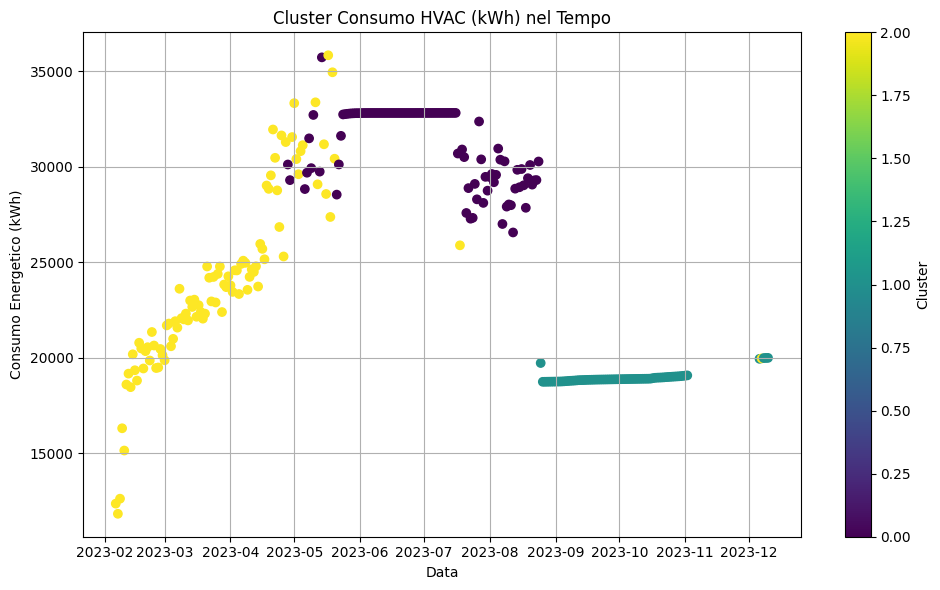

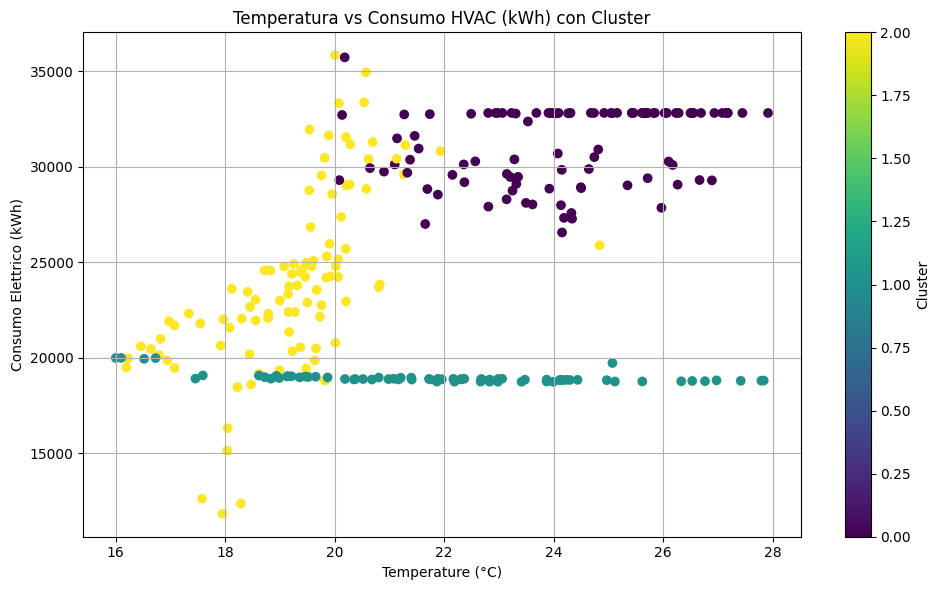

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Filtra solo le colonne rilevanti (Temperature(°C), Pressure(mb), CO2(ppm) e Humidity(HR%))
df_meteo_selezionato = df_combinato2[['Date', 'Temperature(°C)', 'Pressure(mb)', 'CO2(ppm)', 'Humidity(HR%)']]

# Assicurati che le colonne siano numeriche, usa .loc per evitare SettingWithCopyWarning
df_meteo_selezionato.loc[:, 'Temperature(°C)'] = pd.to_numeric(df_meteo_selezionato['Temperature(°C)'], errors='coerce')
df_meteo_selezionato.loc[:, 'Pressure(mb)'] = pd.to_numeric(df_meteo_selezionato['Pressure(mb)'], errors='coerce')
df_meteo_selezionato.loc[:, 'CO2(ppm)'] = pd.to_numeric(df_meteo_selezionato['CO2(ppm)'], errors='coerce')
df_meteo_selezionato.loc[:, 'Humidity(HR%)'] = pd.to_numeric(df_meteo_selezionato['Humidity(HR%)'], errors='coerce')

# Imposta 'Date' come indice
df_meteo_selezionato = df_meteo_selezionato.set_index('Date')

# Esegui il resampling giornaliero e calcola la media per ciascuna variabile
df_meteo_resampled = df_meteo_selezionato.resample('D').mean()
# Reset dell'indice se necessario
df_meteo_resampled = df_meteo_resampled.reset_index()
# Filtra il DataFrame
df_meteo_resampled = df_meteo_resampled[(df_meteo_resampled['Date'] >= prima_data) & (df_meteo_resampled['Date'] < data_primadeidatimancanti + timedelta(days=1)
)]


# Unione dei dati energetici e meteo
df_finale = pd.merge(df_consumo_elettrico_resampled, df_numerico_hvac_resampled, on='dateTime')
df_finale = pd.merge(df_finale, df_meteo_resampled, left_on='dateTime', right_on='Date')
df_finale = df_finale.rename(columns={"Valore_x": "Valore_elettrico"})
df_finale = df_finale.rename(columns={"Valore_y": "Valore_hvac"})

# Filtra solo le colonne numeriche per il clustering
df_clustering = df_finale[['Valore_elettrico', 'Valore_hvac', 'Temperature(°C)', 'Pressure(mb)', 'CO2(ppm)', 'Humidity(HR%)']]

# Gestione dei NaN: sostituisci i NaN con la mediana
df_clustering = df_clustering.fillna(df_clustering.median())

# Normalizza i dati
scaler = StandardScaler()
df_clustering_scaled = scaler.fit_transform(df_clustering)

# Esegui il clustering K-Means
kmeans = KMeans(n_clusters=3, random_state=42)  # Ad esempio, 3 cluster
df_finale['Cluster'] = kmeans.fit_predict(df_clustering_scaled)

# Visualizzazione dei cluster con scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df_finale['dateTime'], df_finale['Valore_elettrico'], c=df_finale['Cluster'], cmap='viridis', label='Consumo Elettrico')
plt.title('Cluster Consumo Elettrico (kWh) nel Tempo')
plt.xlabel('Data')
plt.ylabel('Consumo Elettrico (kWh)')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()


# Scatter plot: Temperatura vs Consumo Elettrico, colorato per Cluster
plt.figure(figsize=(10, 6))
plt.scatter(df_finale['Temperature(°C)'], df_finale['Valore_elettrico'], c=df_finale['Cluster'], cmap='viridis')
plt.title('Temperatura vs Consumo Elettrico con Cluster')
plt.xlabel('Temperature (°C)')
plt.ylabel('Consumo Elettrico (kWh)')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualizzazione dei cluster con scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df_finale['dateTime'], df_finale['Valore_hvac'], c=df_finale['Cluster'], cmap='viridis', label='Consumo Elettrico')
plt.title('Cluster Consumo HVAC (kWh) nel Tempo')
plt.xlabel('Data')
plt.ylabel('Consumo Energetico (kWh)')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

# Scatter plot: Temperatura vs Consumo Elettrico, colorato per Cluster
plt.figure(figsize=(10, 6))
plt.scatter(df_finale['Temperature(°C)'], df_finale['Valore_hvac'], c=df_finale['Cluster'], cmap='viridis')
plt.title('Temperatura vs Consumo HVAC (kWh) con Cluster')
plt.xlabel('Temperature (°C)')
plt.ylabel('Consumo Elettrico (kWh)')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipykernel_180543/1003064973.py:37: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


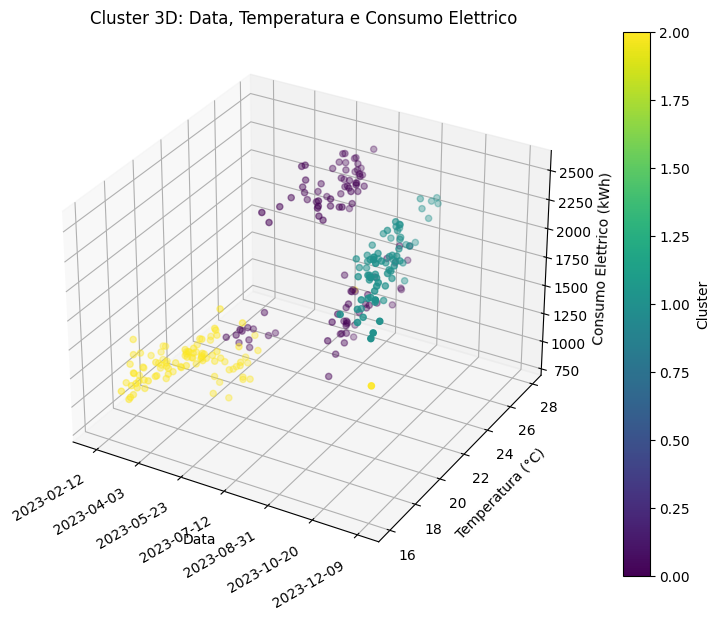

/tmp/ipykernel_180543/1003064973.py:68: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


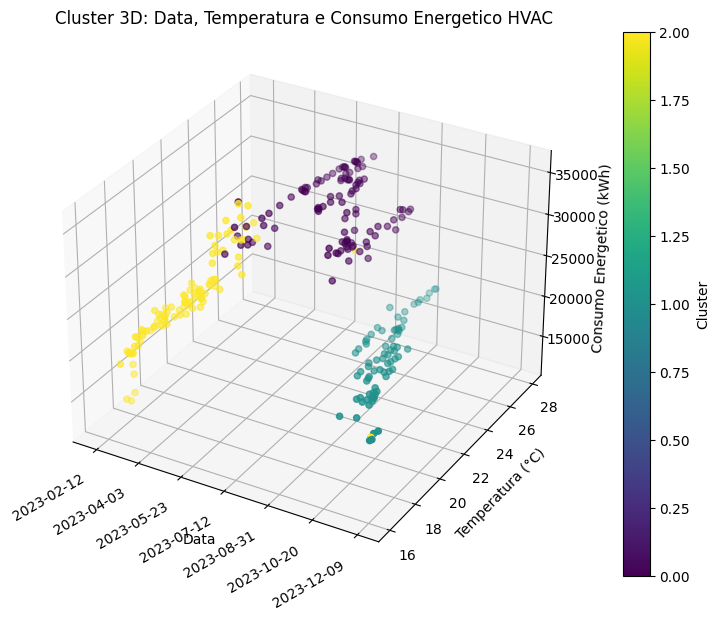

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import matplotlib.dates as mdates

# Converti le date in numeri per il plotting
df_finale['date_num'] = mdates.date2num(df_finale['dateTime'])

# Crea la figura e l'asse 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Crea lo scatter plot 3D
scatter = ax.scatter(df_finale['date_num'], 
                     df_finale['Temperature(°C)'],
                     df_finale['Valore_elettrico'],
                     c=df_finale['Cluster'],
                     cmap='viridis')

# Imposta le etichette degli assi
ax.set_xlabel('Data')
ax.set_ylabel('Temperatura (°C)')
ax.set_zlabel('Consumo Elettrico (kWh)')

# Imposta il formato delle date sull'asse x
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()  # Ruota e allinea le etichette delle date

# Aggiungi il titolo
plt.title('Cluster 3D: Data, Temperatura e Consumo Elettrico')

# Aggiungi una barra dei colori
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster')

# Mostra il grafico
plt.tight_layout()
plt.show()

# Crea la figura e l'asse 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Crea lo scatter plot 3D
scatter = ax.scatter(df_finale['date_num'], 
                     df_finale['Temperature(°C)'],
                     df_finale['Valore_hvac'],
                     c=df_finale['Cluster'],
                     cmap='viridis')

# Imposta le etichette degli assi
ax.set_xlabel('Data')
ax.set_ylabel('Temperatura (°C)')
ax.set_zlabel('Consumo Energetico (kWh)')

# Imposta il formato delle date sull'asse x
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()  # Ruota e allinea le etichette delle date

# Aggiungi il titolo
plt.title('Cluster 3D: Data, Temperatura e Consumo Energetico HVAC')

# Aggiungi una barra dei colori
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster')

# Mostra il grafico
plt.tight_layout()
plt.show()

In [19]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Crea una cartella per salvare le immagini
output_folder = "plots"
os.makedirs(output_folder, exist_ok=True)

# Plot 1: Electrical Consumption Over Time
plt.figure(figsize=(10, 6))
plt.plot(df_consumo_elettrico_resampled['dateTime'], df_consumo_elettrico_resampled['Valore'], label='Electrical Consumption (PC and Lighting)', color='blue')
plt.title('Electrical Consumption Over Time (PC and Lighting)')
plt.xlabel('Date')
plt.ylabel('Electrical Consumption (kWh)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{output_folder}/Electrical_Consumption.png")
plt.close()

# Plot 2: HVAC Consumption Over Time
plt.figure(figsize=(10, 6))
plt.plot(df_numerico_hvac_resampled['dateTime'], df_numerico_hvac_resampled['Valore'], label='Heating (HVAC)', color='red')
plt.title('HVAC Consumption Over Time')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (kWh)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{output_folder}/HVAC_Consumption.png")
plt.close()

# Plot 3: Scatterplot between Electric and HVAC Consumption
plt.figure(figsize=(10, 6))
sns.scatterplot(x='dateTime', y='consumption', hue='type_consumption', data=df_long)
plt.title('Scatterplot between Electric and HVAC Consumption')
plt.xlabel('Date')
plt.ylabel('Consumption (kWh)')
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{output_folder}/Electric_HVAC_Scatterplot.png")
plt.close()

# Plot 4: Daily Average Temperature
plt.figure(figsize=(10, 6))
plt.plot(df_meteo_resampled['Date'], df_meteo_resampled['Temperature(°C)'], label='Temperature (°C)', color='blue')
plt.title('Daily Average Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{output_folder}/Daily_Average_Temperature.png")
plt.close()

# Plot 5: Daily Average Pressure
plt.figure(figsize=(10, 6))
plt.plot(df_meteo_resampled['Date'], df_meteo_resampled['Pressure(mb)'], label='Pressure (mb)', color='green')
plt.title('Daily Average Pressure')
plt.xlabel('Date')
plt.ylabel('Pressure (mb)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{output_folder}/Daily_Average_Pressure.png")
plt.close()

# Plot 6: Daily Average CO2 Levels
plt.figure(figsize=(10, 6))
plt.plot(df_meteo_resampled['Date'], df_meteo_resampled['CO2(ppm)'], label='CO2 (ppm)', color='red')
plt.title('Daily Average CO2 Levels')
plt.xlabel('Date')
plt.ylabel('CO2 (ppm)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{output_folder}/Daily_Average_CO2.png")
plt.close()

# Plot 7: Daily Average Humidity
plt.figure(figsize=(10, 6))
plt.plot(df_meteo_resampled['Date'], df_meteo_resampled['Humidity(HR%)'], label='Humidity (HR%)', color='purple')
plt.title('Daily Average Humidity')
plt.xlabel('Date')
plt.ylabel('Humidity (HR%)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{output_folder}/Daily_Average_Humidity.png")
plt.close()


In [14]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D

# Crea una cartella per salvare le immagini
output_folder = "plots"
os.makedirs(output_folder, exist_ok=True)

# Plot: Correlation Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Electrical Consumption, HVAC, Weather Conditions, and Temporal Components')
plt.tight_layout()
plt.savefig(f"{output_folder}/Correlation_Heatmap.png")
plt.close()

# Plot: Electrical Consumption Clusters Over Time
plt.figure(figsize=(10, 6))
plt.scatter(df_finale['dateTime'], df_finale['Valore_elettrico'], c=df_finale['Cluster'], cmap='viridis')
plt.title('Electrical Consumption Clusters (kWh) Over Time')
plt.xlabel('Date')
plt.ylabel('Electrical Consumption (kWh)')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{output_folder}/Electrical_Consumption_Clusters.png")
plt.close()

# Scatter plot: Temperature vs Electrical Consumption with Clusters
plt.figure(figsize=(10, 6))
plt.scatter(df_finale['Temperature(°C)'], df_finale['Valore_elettrico'], c=df_finale['Cluster'], cmap='viridis')
plt.title('Temperature vs Electrical Consumption with Clusters')
plt.xlabel('Temperature (°C)')
plt.ylabel('Electrical Consumption (kWh)')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{output_folder}/Temperature_vs_Electrical_Consumption.png")
plt.close()

# Plot: HVAC Consumption Clusters Over Time
plt.figure(figsize=(10, 6))
plt.scatter(df_finale['dateTime'], df_finale['Valore_hvac'], c=df_finale['Cluster'], cmap='viridis')
plt.title('HVAC Consumption Clusters (kWh) Over Time')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (kWh)')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{output_folder}/HVAC_Consumption_Clusters.png")
plt.close()

# Scatter plot: Temperature vs HVAC Consumption with Clusters
plt.figure(figsize=(10, 6))
plt.scatter(df_finale['Temperature(°C)'], df_finale['Valore_hvac'], c=df_finale['Cluster'], cmap='viridis')
plt.title('Temperature vs HVAC Consumption (kWh) with Clusters')
plt.xlabel('Temperature (°C)')
plt.ylabel('HVAC Consumption (kWh)')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{output_folder}/Temperature_vs_HVAC_Consumption.png")
plt.close()

# 3D Scatter plot: Date, Temperature, and Electrical Consumption with Clusters
df_finale['date_num'] = mdates.date2num(df_finale['dateTime'])

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df_finale['date_num'], df_finale['Temperature(°C)'], df_finale['Valore_elettrico'], c=df_finale['Cluster'], cmap='viridis')

ax.set_xlabel('Date')
ax.set_ylabel('Temperature (°C)')
ax.set_zlabel('Electrical Consumption (kWh)')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()
plt.title('3D Clustering: Date, Temperature, and Electrical Consumption')
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster')
plt.tight_layout()
plt.savefig(f"{output_folder}/3D_Cluster_Electrical_Consumption.png")
plt.close()

# 3D Scatter plot: Date, Temperature, and HVAC Consumption with Clusters
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df_finale['date_num'], df_finale['Temperature(°C)'], df_finale['Valore_hvac'], c=df_finale['Cluster'], cmap='viridis')

ax.set_xlabel('Date')
ax.set_ylabel('Temperature (°C)')
ax.set_zlabel('HVAC Consumption (kWh)')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()
plt.title('3D Clustering: Date, Temperature, and HVAC Consumption')
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster')
plt.tight_layout()
plt.savefig(f"{output_folder}/3D_Cluster_HVAC_Consumption.png")
plt.close()


/tmp/ipykernel_180543/1092998476.py:82: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
/tmp/ipykernel_180543/1092998476.py:99: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
